### The object of this project is to make a comparison of the "classical" knn method and a new method proposed by [Dend et al., 2015] (Deng, Z., Zhu, X., Cheng, D., Zong, M., and Zhang, S. (2016). Efficient knn classification algorithm for big data. Neurocomputing, 195:143–148. Learning for Medical Imaging.)

### To make the comparison, we will use two datasets: GISETTE and OPTDIGITS.
+ GISETTE is is a handwritten digit recognition problem. The problem is to
separate the highly confusible digits ’4’ and ’9’. This dataset is one of five datasets of
the NIPS 2003 feature selection challenge
+ OPTDIGITS is a handwritten digit recognition problem. 

### We will use the "classical" KNN method from the library scikit-learn and we will develop the new method using the library pyspark.

In [1]:
!pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyspark import SparkContext
sc=SparkContext(master='local[2]')

In [3]:
 #lanch UI
sc

<SparkContext master=local[2] appName=pyspark-shell>

In [4]:
#Create a spark session
from pyspark.sql import SparkSession

In [5]:
spark=SparkSession.builder.appName("AdvancedTopicML").getOrCreate()

In [6]:
import numpy as np
import pandas as pd

# Data retrieving and preprocessing

## Gisette dataset

In [7]:
# read the file gisette_db/gisette-train.data
# and convert it to a pandas dataframe
gisette_data = pd.read_csv('gisette-db/gisette_train.data', sep=' ', header=None)
gisette_data

0     1     2     3     4     5     6     7     8     9     ...  4991  \
0      550     0   495     0     0     0     0   976     0     0  ...     0   
1        0     0     0     0     0     0     0   976     0     0  ...   475   
2        0     0     0     0     0     0     0     0     0     0  ...     0   
3        0     0   742     0     0     0     0   684     0   956  ...     0   
4        0     0     0     0     0     0     0   608     0   979  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
5995     0     0     0     0     0     0     0     0     0     0  ...     0   
5996     0     0     0     0     0     0     0     0     0     0  ...     0   
5997     0     0     0     0     0   758     0     0     0   522  ...   901   
5998     0     0     0     0     0     0     0     0     0     0  ...     0   
5999     0     0   991     0     0     0     0     0     0     0  ...     0   

      4992  4993  4994  4995  4996  4997  4998  4999  5000  
0        0   991   991     0     0     0     0   983   NaN  
1        0   991     0     0   991     0     0     0   NaN  
2        0     0     0     0     0     0     0     0   NaN  
3        0     0     0     0   674     0     0   838   NaN  
4        0   828     0     0     0     0     0     0   NaN  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
5995     0     0     0     0   783     0     0     0   NaN  
5996     0     0     0     0   921     0   886     0   NaN  
5997     0     0     0     0   980     0     0     0   NaN  
5998     0     0   690     0     0     0     0     0   NaN  
5999     0   288     0     0   972     0     0   991   NaN  

[6000 rows x 5001 columns]

In [8]:
gisette_label = pd.read_csv('gisette-db/gisette_train.labels', sep=' ', header=None)

In [9]:
gisette_label

0
0     1
1    -1
2     1
3     1
4     1
...  ..
5995 -1
5996  1
5997 -1
5998 -1
5999 -1

[6000 rows x 1 columns]

In [10]:
# replace Nan with 0
gisette_data = gisette_data.fillna(0)

## Optdigit dataset

In [11]:
# import optdigits-db/optdigits.tra
# and convert it to a pandas dataframe
optdigits_data = pd.read_csv('optdigits-db/optdigits.tra', sep=',', header=None)
optdigits_data

0   1   2   3   4   5   6   7   8   9   ...  55  56  57  58  59  60  61  \
0      0   1   6  15  12   1   0   0   0   7  ...   0   0   0   6  14   7   1   
1      0   0  10  16   6   0   0   0   0   7  ...   0   0   0  10  16  15   3   
2      0   0   8  15  16  13   0   0   0   1  ...   0   0   0   9  14   0   0   
3      0   0   0   3  11  16   0   0   0   0  ...   0   0   0   0   1  15   2   
4      0   0   5  14   4   0   0   0   0   0  ...   0   0   0   4  12  14   7   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
3818   0   0   5  13  11   2   0   0   0   2  ...   0   0   0   8  13  15  10   
3819   0   0   0   1  12   1   0   0   0   0  ...   0   0   0   0   4   9   0   
3820   0   0   3  15   0   0   0   0   0   0  ...   0   0   0   4  14  16   9   
3821   0   0   6  16   2   0   0   0   0   0  ...   0   0   0   5  16  16  16   
3822   0   0   2  15  16  13   1   0   0   0  ...   0   0   0   4  14   1   0   

      62  63  64  
0      0   0   0  
1      0   0   0  
2      0   0   7  
3      0   0   4  
4      0   0   6  
...   ..  ..  ..  
3818   1   0   9  
3819   0   0   4  
3820   0   0   6  
3821   5   0   6  
3822   0   0   7  

[3823 rows x 65 columns]

In [12]:
optdigits_label = optdigits_data[64]
optdigits_data = optdigits_data.drop(64, axis=1)
optdigits_label

0       0
1       0
2       7
3       4
4       6
       ..
3818    9
3819    4
3820    6
3821    6
3822    7
Name: 64, Length: 3823, dtype: int64

# Making a "classical" KNN model for comparison

### We will use 4 metrics to compare the two methods: accuracy, precision, recall and F1-score. We will also measure the time

+ optdigits dataset

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [14]:
optdigit_train_data, optdigit_test_data, optdigit_train_label, optdigit_test_label = train_test_split(optdigits_data, optdigits_label, test_size=0.2, random_state=42)

In [15]:
knn = KNeighborsClassifier(n_neighbors=3)

In [16]:
knn.fit(optdigit_train_data, optdigit_train_label)

KNeighborsClassifier(n_neighbors=3)

In [17]:
# prediction
# record the time
import time
start_opt = time.time()
predict = knn.predict(optdigit_test_data)
end_opt = time.time()


### Accuracy, precision, recall and F1-score

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [19]:
acc_opt = accuracy_score(optdigit_test_label, predict)
prec_opt = precision_score(optdigit_test_label, predict, average='macro')
rec_opt = recall_score(optdigit_test_label, predict, average='macro')
f1_opt = f1_score(optdigit_test_label, predict, average='macro')


In [20]:
print('Accuracy: ', acc_opt, '\nPrecision', prec_opt,
      '\nRecall', rec_opt, '\nF1', f1_opt, '\nTime', end_opt-start_opt, 's')


Accuracy:  0.984313725490196 
Precision 0.9847688494865668 
Recall 0.9848506588806535 
F1 0.984685110583763 
Time 0.24266815185546875 s


+ GISETTE dataset

In [21]:
gisette_train_data, gisette_test_data, gisette_train_label, gisette_test_label = train_test_split(gisette_data, gisette_label, test_size=0.2, random_state=42)

In [22]:
knn = KNeighborsClassifier(n_neighbors=3)

In [23]:
knn.fit(gisette_train_data, gisette_train_label)

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=3)

In [24]:
start_gisette = time.time()
predict = knn.predict(gisette_test_data)
end_gisette = time.time()


In [25]:
len(predict)


1200

In [26]:
acc_gisette = accuracy_score(gisette_test_label, predict)
prec_gisette = precision_score(gisette_test_label, predict, average='macro')
rec_gisette = recall_score(gisette_test_label, predict, average='macro')
f1_gisette = f1_score(gisette_test_label, predict, average='macro')


In [27]:
print('Accuracy: ', acc_gisette, '\nPrecision', prec_gisette,
      '\nRecall', rec_gisette, '\nF1', f1_gisette, '\nTime', end_gisette-start_gisette, 's')


Accuracy:  0.9691666666666666 
Precision 0.9700124611978327 
Recall 0.9694444521615442 
F1 0.9691618482054487 
Time 0.8753707408905029 s


# Visualizing the results of the classical KNN models

In [28]:
# make a dataframe to store the results of gisette
results = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1', 'Time'])
results.loc['Gisette classical KNN'] = [acc_gisette, prec_gisette, rec_gisette, f1_gisette, end_gisette-start_gisette]
results.loc['Optdigits classical KNN'] = [acc_opt, prec_opt, rec_opt, f1_opt, end_opt-start_opt]

In [29]:
results

Accuracy  Precision    Recall        F1      Time
Gisette classical KNN    0.969167   0.970012  0.969444  0.969162  0.875371
Optdigits classical KNN  0.984314   0.984769  0.984851  0.984685  0.242668

In [30]:
results.to_latex('results-classical-KNN.tex')

C:\Users\HP\AppData\Local\Temp\ipykernel_16056\305113872.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  results.to_latex('results-classical-KNN.tex')


# KNN classification for Big Data with Spark

### The [Deng et al., 2015] algortihm is the following:

### - Produce m cluster centers using LSC algorithm, denoted by C = {c1, c2, ..., cm}

In [31]:
from sklearn.cluster import SpectralClustering

In [32]:
sp = SpectralClustering(n_clusters=20, random_state=42)

+ For Gisette dataset

In [33]:
sp.fit(gisette_train_data)

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


SpectralClustering(n_clusters=20, random_state=42)

In [34]:
# group the indices with similar labels in the same cluster
cluster = {}
for i in range(len(sp.labels_)):
    if sp.labels_[i] not in cluster:
        cluster[sp.labels_[i]] = [i]
    else:
        cluster[sp.labels_[i]].append(i)


In [35]:
cluster[3]

[0,
 1,
 2,
 3,
 4,
 6,
 8,
 9,
 10,
 11,
 13,
 16,
 17,
 18,
 20,
 22,
 23,
 24,
 25,
 27,
 28,
 30,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 59,
 60,
 61,
 63,
 64,
 65,
 66,
 67,
 69,
 70,
 73,
 74,
 75,
 76,
 78,
 79,
 81,
 83,
 84,
 85,
 86,
 87,
 89,
 92,
 93,
 95,
 96,
 97,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 108,
 110,
 111,
 117,
 119,
 120,
 122,
 123,
 124,
 125,
 129,
 130,
 131,
 133,
 135,
 137,
 138,
 139,
 140,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 150,
 151,
 153,
 155,
 156,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 166,
 167,
 169,
 170,
 172,
 173,
 174,
 176,
 177,
 178,
 181,
 182,
 184,
 185,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 199,
 200,
 201,
 204,
 205,
 206,
 207,
 208,
 210,
 211,
 213,
 214,
 216,
 217,
 218,
 221,
 222,
 223,
 224,
 225,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 235,
 236,
 238,
 240,
 241,
 242,
 243,
 244,
 245,
 2

In [36]:
for i in range(len(cluster)):
    print('Cluster ', i, 'has ', len(cluster[i]), 'elements')

Cluster  0 has  22 elements
Cluster  1 has  229 elements
Cluster  2 has  1 elements
Cluster  3 has  3608 elements
Cluster  4 has  1 elements
Cluster  5 has  97 elements
Cluster  6 has  47 elements
Cluster  7 has  15 elements
Cluster  8 has  174 elements
Cluster  9 has  46 elements
Cluster  10 has  68 elements
Cluster  11 has  9 elements
Cluster  12 has  1 elements
Cluster  13 has  7 elements
Cluster  14 has  135 elements
Cluster  15 has  36 elements
Cluster  16 has  1 elements
Cluster  17 has  233 elements
Cluster  18 has  64 elements
Cluster  19 has  6 elements


In [37]:
centers = []
for i in range(len(cluster)):
    centers.append(np.mean(gisette_train_data.iloc[cluster[i]], axis=0))

centers

[0        39.227273
 1         0.000000
 2       225.818182
 3         0.000000
 4         0.000000
            ...    
 4996    344.136364
 4997     54.590909
 4998    177.818182
 4999    199.090909
 5000      0.000000
 Length: 5001, dtype: float64,
 0       165.301310
 1         0.000000
 2       168.266376
 3         0.000000
 4        14.056769
            ...    
 4996    212.825328
 4997      8.633188
 4998    122.602620
 4999    160.104803
 5000      0.000000
 Length: 5001, dtype: float64,
 0         0.0
 1         0.0
 2       979.0
 3         0.0
 4         0.0
         ...  
 4996      0.0
 4997      0.0
 4998    511.0
 4999    960.0
 5000      0.0
 Length: 5001, dtype: float64,
 0       105.002494
 1        11.806541
 2       173.562084
 3         1.339800
 4        14.213415
            ...    
 4996    266.480876
 4997     16.502772
 4998    127.734756
 4999    157.918514
 5000      0.000000
 Length: 5001, dtype: float64,
 0         0.0
 1         0.0
 2         0.0
 3    

In [38]:
len(centers)

20

+ For Optdigits dataset

In [39]:
sp = SpectralClustering(n_clusters=20, random_state=42)

In [40]:
sp.fit(optdigit_train_data)

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:289: ConvergenceWarning: Number of distinct clusters (19) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  est = KMeans(


SpectralClustering(n_clusters=20, random_state=42)

In [41]:
cluster_opt = {}
for i in range(len(sp.labels_)):
    if sp.labels_[i] not in cluster_opt:
        cluster_opt[sp.labels_[i]] = [i]
    else:
        cluster_opt[sp.labels_[i]].append(i)

In [42]:
centers_opt = []
for i in range(len(cluster_opt)):
    centers_opt.append(np.mean(optdigit_train_data.iloc[cluster_opt[i]], axis=0))

In [43]:
centers_opt

[0      0.0
 1      0.0
 2      4.0
 3     14.0
 4     14.0
       ... 
 59    12.0
 60    16.0
 61    10.0
 62     0.0
 63     0.0
 Length: 64, dtype: float64,
 0      0.0
 1      0.0
 2      0.0
 3     10.0
 4      7.0
       ... 
 59    11.0
 60    15.0
 61     2.0
 62     0.0
 63     0.0
 Length: 64, dtype: float64,
 0      0.0
 1      0.0
 2      6.0
 3      9.0
 4      4.0
       ... 
 59    10.0
 60    13.0
 61     1.0
 62     0.0
 63     0.0
 Length: 64, dtype: float64,
 0      0.0
 1      2.0
 2      4.0
 3      7.0
 4     13.0
       ... 
 59     7.0
 60    16.0
 61     9.0
 62     0.0
 63     0.0
 Length: 64, dtype: float64,
 0      0.0
 1      2.0
 2     11.0
 3      3.0
 4      0.0
       ... 
 59    15.0
 60     5.0
 61     0.0
 62     0.0
 63     0.0
 Length: 64, dtype: float64,
 0      0.0
 1      0.5
 2      9.5
 3     15.0
 4      7.5
       ... 
 59    16.0
 60    14.0
 61     0.0
 62     0.0
 63     0.0
 Length: 64, dtype: float64,
 0      0.0
 1      0.0
 2      5.

In [55]:
for i in range(len(cluster_opt)):
    print('Cluster ', i, 'has ', len(cluster_opt[i]), 'elements')

Cluster  0 has  1 elements
Cluster  1 has  1 elements
Cluster  2 has  1 elements
Cluster  3 has  1 elements
Cluster  4 has  1 elements
Cluster  5 has  2 elements
Cluster  6 has  1 elements
Cluster  7 has  1 elements
Cluster  8 has  1 elements
Cluster  9 has  1 elements
Cluster  10 has  1 elements
Cluster  11 has  1 elements
Cluster  12 has  1 elements
Cluster  13 has  1 elements
Cluster  14 has  1 elements
Cluster  15 has  1 elements
Cluster  16 has  1 elements
Cluster  17 has  3039 elements
Cluster  18 has  1 elements


### - Compute the distance D(y,Ci) between each test sample y and each cluster center,denoted by D(y,Ci), i = 1,2,…,m;

In [44]:
from math import dist

+ For Gisette dataset

In [45]:
distances = {}
for i in range(gisette_test_data.shape[0]):
    distances[i] = []
    for j in range(len(centers)):
        distances[i].append((j, dist(gisette_test_data.iloc[i], centers[j])))

In [46]:
distances

{0: [(0, 16473.60812158006),
  (1, 15702.879015853418),
  (2, 24504.369447100653),
  (3, 15798.649268785564),
  (4, 23128.624948318913),
  (5, 15822.114883643753),
  (6, 16106.001578946374),
  (7, 16558.396791691855),
  (8, 15694.276191839006),
  (9, 15936.392664937617),
  (10, 15859.083786688332),
  (11, 16952.252414529637),
  (12, 28096.951756373855),
  (13, 17748.85838352336),
  (14, 15694.59775780727),
  (15, 15929.531059302722),
  (16, 20620.854298500824),
  (17, 15792.867677084929),
  (18, 16204.11157903814),
  (19, 17531.02558877958)],
 1: [(0, 17980.711662974434),
  (1, 17574.44832263718),
  (2, 25596.10616871246),
  (3, 17492.90206751291),
  (4, 25233.398641483076),
  (5, 17440.09325318764),
  (6, 17605.002869390162),
  (7, 17605.255385190463),
  (8, 17592.598270249004),
  (9, 17560.912034271605),
  (10, 17529.139934615112),
  (11, 17824.38930334044),
  (12, 28416.97874510941),
  (13, 19351.047858038117),
  (14, 17434.35898495858),
  (15, 17577.590758701866),
  (16, 24522.2226

+ For Optdigits dataset

In [47]:
distances_opt = {}
for i in range(optdigit_test_data.shape[0]):
    distances_opt[i] = []
    for j in range(len(centers_opt)):
        distances_opt[i].append((j, dist(optdigit_test_data.iloc[i], centers_opt[j])))

### - Compute the nearest cluster center Ci to y, Ci = min{D(y,Ci)}, i = 1,2,…,m;
### - Using the corresponding cluster of Ci as the training dataset, denoted by NewXi;
### - Apply kNN algorithm to predict y in the training dataset

+ For Gisette dataset

In [48]:
for i in range(len(distances)):
    distances[i] = sorted(distances[i], key=lambda x: x[1])
    

In [49]:
prediction_gisette = []
temps = []
for i in range(len(distances)):
    knn = KNeighborsClassifier(n_neighbors=3)
    deb = time.time()
    knn.fit(gisette_train_data.iloc[cluster[distances[i][0][0]]], gisette_train_label.iloc[cluster[distances[i][0][0]]])
    prediction_gisette.append(knn.predict(gisette_test_data.iloc[i].values.reshape(1, -1))[0])
    end = time.time()
    temps.append(end-deb)


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWa

In [50]:
acc_gis = accuracy_score(gisette_test_label, prediction_gisette)
prec_gis = precision_score(gisette_test_label, prediction_gisette, average='macro')
rec_gis = recall_score(gisette_test_label, prediction_gisette, average='macro')
f1_gis = f1_score(gisette_test_label, prediction_gisette, average='macro')

In [51]:
res_gis_spectral = [acc_gis, prec_gis, rec_gis, f1_gis, np.mean(temps)]

In [52]:
print('Accuracy: ', acc_gis, '\nPrecision', prec_gis,
        '\nRecall', rec_gis, '\nF1', f1_gis, '\nTime', np.mean(temps), 's')

Accuracy:  0.8825 
Precision 0.8842332396627861 
Recall 0.8829021172326234 
F1 0.8824313366347984 
Time 0.04189286053180694 s


+ For Optdigits dataset

In [53]:
for i in range(len(distances_opt)):
    distances_opt[i] = sorted(distances_opt[i], key=lambda x: x[1])

In [56]:
prediction_opt = []
temps_opt = []
for i in range(len(distances_opt)):
    knn = KNeighborsClassifier(n_neighbors=1)
    deb = time.time()
    knn.fit(optdigit_train_data.iloc[cluster_opt[distances_opt[i][0][0]]], optdigit_train_label.iloc[cluster_opt[distances_opt[i][0][0]]])
    prediction_opt.append(knn.predict(optdigit_test_data.iloc[i].values.reshape(1, -1))[0])
    end = time.time()
    temps_opt.append(end-deb)

In [163]:
acc_opt = accuracy_score(optdigit_test_label, prediction_opt)
prec_opt = precision_score(optdigit_test_label, prediction_opt, average='macro')
rec_opt = recall_score(optdigit_test_label, prediction_opt, average='macro')
f1_opt = f1_score(optdigit_test_label, prediction_opt, average='macro')


In [164]:
res_opt_spectral = [acc_opt, prec_opt, rec_opt, f1_opt, np.mean(temps_opt)]

In [165]:
print('Accuracy: ', acc_opt, '\nPrecision', prec_opt,
        '\nRecall', rec_opt, '\nF1', f1_opt, '\nTime', np.mean(temps_opt), 's') 

Accuracy:  0.8614379084967321 
Precision 0.879212355031268 
Recall 0.8744856406141999 
F1 0.8694843241360711 
Time 0.011643332126093846 s


In [59]:
results.loc['Gisette spectral KNN'] = res_gis_spectral
results

Accuracy  Precision    Recall        F1      Time
Gisette classical KNN    0.969167   0.970012  0.969444  0.969162  0.875371
Optdigits classical KNN  0.984314   0.984769  0.984851  0.984685  0.242668
Gisette spectral KNN     0.882500   0.884233  0.882902  0.882431  0.041893

In [60]:
# Select the first and the third rows of the dataframe and export to latex
results.iloc[[0, 2]].to_latex('results-spectral-KNN-gisette.tex')


C:\Users\HP\AppData\Local\Temp\ipykernel_16056\1455597016.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  results.iloc[[0, 2]].to_latex('results-spectral-KNN.tex')


In [166]:
results.loc['Optdigits spectral KNN'] = res_opt_spectral

In [167]:
results.iloc[[1, 3]].to_latex('results-spectral-KNN-optdigits.tex')

C:\Users\HP\AppData\Local\Temp\ipykernel_16056\3614524057.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  results.iloc[[1, 3]].to_latex('results-spectral-KNN-optdigits.tex')


# Visualizing the results of the new KNN models

In [62]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

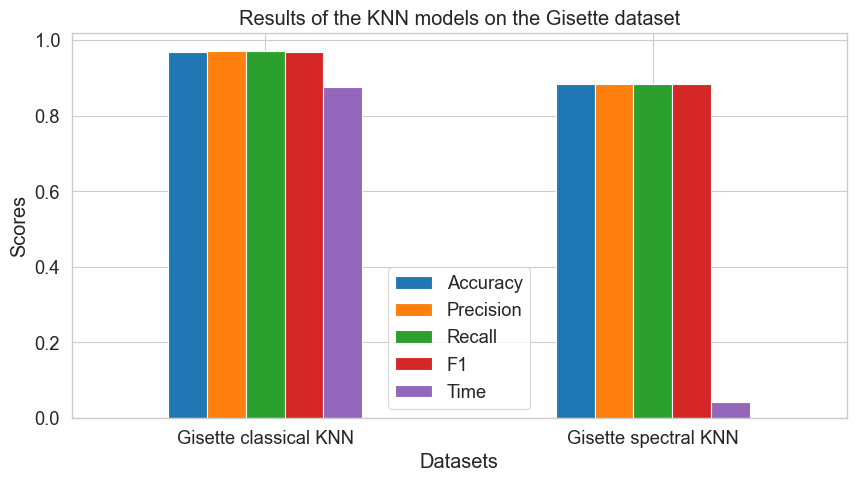

In [156]:
# Make a barplot of the first and third row of the results dataframe
results.iloc[[0, 2]].plot.bar(rot=0, figsize=(10, 5))
plt.title('Results of the KNN models on the Gisette dataset')
plt.xlabel('Datasets')
plt.ylabel('Scores')
plt.savefig('results-spectral-KNN-gisette.png')
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

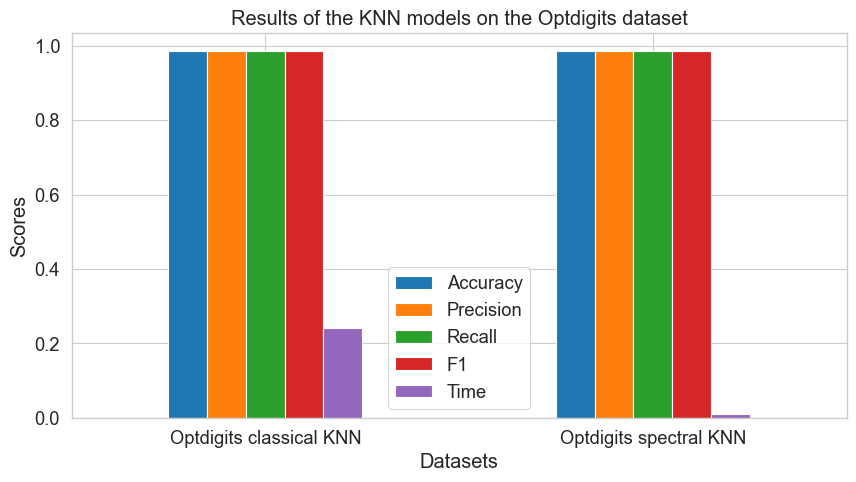

In [155]:
# Make a barplot of the second and forth rows of the results dataframe
results.iloc[[1, 3]].plot.bar(rot=0, figsize=(10, 5))
plt.title('Results of the KNN models on the Optdigits dataset')
plt.xlabel('Datasets')
plt.ylabel('Scores')
plt.savefig('results-spectral-KNN-optdigits.png')
plt.show

# In this part we will make a study of the impact of the number of clusters on the models using the Gisette dataset

In [68]:
res_gisette = []

### - m = 10

In [75]:
sp = SpectralClustering(n_clusters=10, random_state=42)

In [76]:
sp.fit(gisette_train_data)

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


SpectralClustering(n_clusters=10, random_state=42)

In [77]:
# group the indices with similar labels in the same cluster
cluster = {}
for i in range(len(sp.labels_)):
    if sp.labels_[i] not in cluster:
        cluster[sp.labels_[i]] = [i]
    else:
        cluster[sp.labels_[i]].append(i)


In [78]:
for i in range(len(cluster)):
    print('Cluster ', i, 'has ', len(cluster[i]), 'elements')

Cluster  0 has  184 elements
Cluster  1 has  26 elements
Cluster  2 has  153 elements
Cluster  3 has  26 elements
Cluster  4 has  1 elements
Cluster  5 has  52 elements
Cluster  6 has  4312 elements
Cluster  7 has  40 elements
Cluster  8 has  2 elements
Cluster  9 has  4 elements


In [79]:
centers = []
for i in range(len(cluster)):
    centers.append(np.mean(gisette_train_data.iloc[cluster[i]], axis=0))

centers

[0       129.842391
 1         9.739130
 2       191.690217
 3         0.000000
 4         0.000000
            ...    
 4996    258.625000
 4997      5.570652
 4998    119.951087
 4999    109.635870
 5000      0.000000
 Length: 5001, dtype: float64,
 0        70.692308
 1         0.000000
 2       166.076923
 3         0.000000
 4         0.000000
            ...    
 4996    261.384615
 4997     19.884615
 4998    141.076923
 4999    219.807692
 5000      0.000000
 Length: 5001, dtype: float64,
 0       111.026144
 1         9.294118
 2       239.183007
 3         2.764706
 4        15.653595
            ...    
 4996    225.627451
 4997     16.732026
 4998    125.705882
 4999    226.875817
 5000      0.000000
 Length: 5001, dtype: float64,
 0        55.884615
 1         0.000000
 2       232.500000
 3         0.000000
 4         0.000000
            ...    
 4996    214.961538
 4997     19.269231
 4998    130.384615
 4999     75.923077
 5000      0.000000
 Length: 5001, dtype: float

In [80]:
distances = {}
for i in range(gisette_test_data.shape[0]):
    distances[i] = []
    for j in range(len(centers)):
        distances[i].append((j, dist(gisette_test_data.iloc[i], centers[j])))

In [81]:
distances

{0: [(0, 15853.086335030655),
  (1, 15686.064104963667),
  (2, 16056.58568472089),
  (3, 15850.725569088881),
  (4, 28387.567137745355),
  (5, 16018.543785885791),
  (6, 15775.652197541809),
  (7, 15634.759267014635),
  (8, 21136.22547902061),
  (9, 17670.41757960179)],
 1: [(0, 17490.17569542414),
  (1, 17885.82999593508),
  (2, 17785.49063162573),
  (3, 17876.208154685515),
  (4, 30433.843809154307),
  (5, 17130.32880766746),
  (6, 17477.865800242176),
  (7, 17588.06492447364),
  (8, 22239.099723235202),
  (9, 19882.30746008873)],
 2: [(0, 20885.73861145293),
  (1, 21626.938393098448),
  (2, 20449.74935624241),
  (3, 21026.51557487389),
  (4, 31412.225120166193),
  (5, 20237.968237115456),
  (6, 20680.551175084795),
  (7, 21116.428183703323),
  (8, 22460.414032247936),
  (9, 22393.05614331148)],
 3: [(0, 20550.094042635257),
  (1, 21109.9202060318),
  (2, 20276.578129175585),
  (3, 20453.02042931441),
  (4, 31636.159043094976),
  (5, 20479.773497779224),
  (6, 20546.64113847333),
  (

In [82]:
for i in range(len(distances)):
    distances[i] = sorted(distances[i], key=lambda x: x[1])
    

In [83]:
prediction_gisette = []
temps = []
for i in range(len(distances)):
    knn = KNeighborsClassifier(n_neighbors=3)
    deb = time.time()
    knn.fit(gisette_train_data.iloc[cluster[distances[i][0][0]]], gisette_train_label.iloc[cluster[distances[i][0][0]]])
    prediction_gisette.append(knn.predict(gisette_test_data.iloc[i].values.reshape(1, -1))[0])
    end = time.time()
    temps.append(end-deb)


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWa

In [84]:
acc_gis = accuracy_score(gisette_test_label, prediction_gisette)
prec_gis = precision_score(gisette_test_label, prediction_gisette, average='macro')
rec_gis = recall_score(gisette_test_label, prediction_gisette, average='macro')
f1_gis = f1_score(gisette_test_label, prediction_gisette, average='macro')

In [87]:
res_gis_spectral = [10, acc_gis, prec_gis, rec_gis, f1_gis, np.mean(temps)]

In [88]:
print('Accuracy: ', acc_gis, '\nPrecision', prec_gis,
        '\nRecall', rec_gis, '\nF1', f1_gis, '\nTime', np.mean(temps), 's')

Accuracy:  0.915 
Precision 0.9167584140478016 
Recall 0.9153968179002142 
F1 0.914953697012818 
Time 0.1307802744706472 s


In [89]:
res_gisette.append(res_gis_spectral)

### - m = 15

In [90]:
sp = SpectralClustering(n_clusters=15, random_state=42)

In [91]:
sp.fit(gisette_train_data)

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


SpectralClustering(n_clusters=15, random_state=42)

In [92]:
# group the indices with similar labels in the same cluster
cluster = {}
for i in range(len(sp.labels_)):
    if sp.labels_[i] not in cluster:
        cluster[sp.labels_[i]] = [i]
    else:
        cluster[sp.labels_[i]].append(i)


In [93]:
for i in range(len(cluster)):
    print('Cluster ', i, 'has ', len(cluster[i]), 'elements')

Cluster  0 has  99 elements
Cluster  1 has  90 elements
Cluster  2 has  29 elements
Cluster  3 has  1 elements
Cluster  4 has  142 elements
Cluster  5 has  34 elements
Cluster  6 has  334 elements
Cluster  7 has  3721 elements
Cluster  8 has  1 elements
Cluster  9 has  28 elements
Cluster  10 has  288 elements
Cluster  11 has  1 elements
Cluster  12 has  17 elements
Cluster  13 has  2 elements
Cluster  14 has  13 elements


In [94]:
centers = []
for i in range(len(cluster)):
    centers.append(np.mean(gisette_train_data.iloc[cluster[i]], axis=0))

centers

[0        79.626263
 1         9.777778
 2       145.414141
 3         0.000000
 4        23.414141
            ...    
 4996    215.414141
 4997     11.535354
 4998     81.414141
 4999     78.141414
 5000      0.000000
 Length: 5001, dtype: float64,
 0       146.711111
 1         0.000000
 2       159.066667
 3         0.000000
 4        16.911111
            ...    
 4996    346.777778
 4997     33.444444
 4998    130.144444
 4999    152.622222
 5000      0.000000
 Length: 5001, dtype: float64,
 0        78.655172
 1         0.000000
 2       211.034483
 3         0.000000
 4         0.000000
            ...    
 4996    177.413793
 4997      0.000000
 4998     55.862069
 4999     73.448276
 5000      0.000000
 Length: 5001, dtype: float64,
 0         0.0
 1         0.0
 2       999.0
 3         0.0
 4         0.0
         ...  
 4996      0.0
 4997    501.0
 4998      0.0
 4999      0.0
 5000      0.0
 Length: 5001, dtype: float64,
 0       139.323944
 1        10.345070
 2       19

In [95]:
distances = {}
for i in range(gisette_test_data.shape[0]):
    distances[i] = []
    for j in range(len(centers)):
        distances[i].append((j, dist(gisette_test_data.iloc[i], centers[j])))

In [96]:
distances

{0: [(0, 15817.172983171597),
  (1, 15678.532994252104),
  (2, 16147.776763293028),
  (3, 28096.951756373855),
  (4, 15947.772396355893),
  (5, 15961.095413568519),
  (6, 15735.345976335004),
  (7, 15784.389696985141),
  (8, 26535.693358192093),
  (9, 15913.146966022932),
  (10, 15856.313196273371),
  (11, 23128.624948318913),
  (12, 15962.351960278478),
  (13, 22318.493127897324),
  (14, 16746.036937685978)],
 1: [(0, 17424.966704829654),
  (1, 17513.802291230088),
  (2, 17580.430154908867),
  (3, 28416.97874510941),
  (4, 17409.379820774753),
  (5, 17765.04367905368),
  (6, 17584.093689842695),
  (7, 17487.738673589294),
  (8, 26943.20379984533),
  (9, 17555.52931429588),
  (10, 17497.353502799335),
  (11, 25233.398641483076),
  (12, 18180.12381172605),
  (13, 22861.340938361423),
  (14, 17696.94595455225)],
 2: [(0, 21150.618666543854),
  (1, 21099.016352181672),
  (2, 20324.037370865037),
  (3, 30818.121243839636),
  (4, 20655.2058328529),
  (5, 20454.12398028911),
  (6, 20693.9768

In [97]:
for i in range(len(distances)):
    distances[i] = sorted(distances[i], key=lambda x: x[1])
    

In [99]:
prediction_gisette = []
temps = []
for i in range(len(distances)):
    knn = KNeighborsClassifier(n_neighbors=2)
    deb = time.time()
    knn.fit(gisette_train_data.iloc[cluster[distances[i][0][0]]], gisette_train_label.iloc[cluster[distances[i][0][0]]])
    prediction_gisette.append(knn.predict(gisette_test_data.iloc[i].values.reshape(1, -1))[0])
    end = time.time()
    temps.append(end-deb)


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWa

In [100]:
acc_gis = accuracy_score(gisette_test_label, prediction_gisette)
prec_gis = precision_score(gisette_test_label, prediction_gisette, average='macro')
rec_gis = recall_score(gisette_test_label, prediction_gisette, average='macro')
f1_gis = f1_score(gisette_test_label, prediction_gisette, average='macro')

In [101]:
res_gis_spectral = [15, acc_gis, prec_gis, rec_gis, f1_gis, np.mean(temps)]

In [102]:
print('Accuracy: ', acc_gis, '\nPrecision', prec_gis,
        '\nRecall', rec_gis, '\nF1', f1_gis, '\nTime', np.mean(temps), 's')

Accuracy:  0.8683333333333333 
Precision 0.8780642597606054 
Recall 0.8674013963011632 
F1 0.867258124138858 
Time 0.12718332807223 s


In [103]:
res_gisette.append(res_gis_spectral)

### - m = 25

In [104]:
sp = SpectralClustering(n_clusters=25, random_state=42)

In [105]:
sp.fit(gisette_train_data)

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


SpectralClustering(n_clusters=25, random_state=42)

In [106]:
# group the indices with similar labels in the same cluster
cluster = {}
for i in range(len(sp.labels_)):
    if sp.labels_[i] not in cluster:
        cluster[sp.labels_[i]] = [i]
    else:
        cluster[sp.labels_[i]].append(i)


In [107]:
for i in range(len(cluster)):
    print('Cluster ', i, 'has ', len(cluster[i]), 'elements')

Cluster  0 has  62 elements
Cluster  1 has  78 elements
Cluster  2 has  124 elements
Cluster  3 has  63 elements
Cluster  4 has  13 elements
Cluster  5 has  18 elements
Cluster  6 has  48 elements
Cluster  7 has  1 elements
Cluster  8 has  1 elements
Cluster  9 has  90 elements
Cluster  10 has  30 elements
Cluster  11 has  1 elements
Cluster  12 has  26 elements
Cluster  13 has  1962 elements
Cluster  14 has  87 elements
Cluster  15 has  1 elements
Cluster  16 has  1 elements
Cluster  17 has  5 elements
Cluster  18 has  1 elements
Cluster  19 has  68 elements
Cluster  20 has  3 elements
Cluster  21 has  35 elements
Cluster  22 has  2044 elements
Cluster  23 has  1 elements
Cluster  24 has  37 elements


In [108]:
centers = []
for i in range(len(cluster)):
    centers.append(np.mean(gisette_train_data.iloc[cluster[i]], axis=0))

centers

[0       116.870968
 1        33.145161
 2       171.258065
 3         0.000000
 4         0.000000
            ...    
 4996    301.080645
 4997     13.790323
 4998    161.725806
 4999    137.322581
 5000      0.000000
 Length: 5001, dtype: float64,
 0        85.153846
 1        15.102564
 2       192.782051
 3         0.000000
 4        10.461538
            ...    
 4996    225.794872
 4997     18.269231
 4998    148.705128
 4999    134.384615
 5000      0.000000
 Length: 5001, dtype: float64,
 0       140.306452
 1        15.830645
 2       220.782258
 3         4.491935
 4        25.693548
            ...    
 4996    279.362903
 4997      9.548387
 4998    137.354839
 4999    104.056452
 5000      0.000000
 Length: 5001, dtype: float64,
 0       134.603175
 1         0.000000
 2       175.301587
 3         0.000000
 4        39.396825
            ...    
 4996    197.714286
 4997      0.000000
 4998    109.857143
 4999    150.873016
 5000      0.000000
 Length: 5001, dtype: float

In [110]:
distances = {}
for i in range(gisette_test_data.shape[0]):
    distances[i] = []
    for j in range(len(centers)):
        distances[i].append((j, dist(gisette_test_data.iloc[i], centers[j])))

In [111]:
distances

{0: [(0, 15694.659889939447),
  (1, 15891.99024613969),
  (2, 15755.952821566412),
  (3, 15995.654865067521),
  (4, 16522.174174952146),
  (5, 16555.4452226935),
  (6, 16417.778558673806),
  (7, 21837.813008632525),
  (8, 19977.54151541175),
  (9, 15890.92572816012),
  (10, 15989.442308841724),
  (11, 28096.951756373855),
  (12, 16571.685339179272),
  (13, 15794.261309338759),
  (14, 15654.55068867311),
  (15, 23525.70965985936),
  (16, 23595.659134679838),
  (17, 16688.89547932996),
  (18, 23124.784539536795),
  (19, 15805.606757035459),
  (20, 20914.28788067037),
  (21, 16048.20487048),
  (22, 15773.316382914572),
  (23, 24504.369447100653),
  (24, 16181.516946151787)],
 1: [(0, 18084.05269031351),
  (1, 17702.709013574633),
  (2, 17570.625617020334),
  (3, 17606.89056511348),
  (4, 17622.30528025583),
  (5, 17329.002823444232),
  (6, 17893.447156291113),
  (7, 23974.5758252362),
  (8, 23391.678734113975),
  (9, 17622.882255374403),
  (10, 17128.14391231902),
  (11, 28416.97874510941

In [112]:
for i in range(len(distances)):
    distances[i] = sorted(distances[i], key=lambda x: x[1])
    

In [113]:
prediction_gisette = []
temps = []
for i in range(len(distances)):
    knn = KNeighborsClassifier(n_neighbors=3)
    deb = time.time()
    knn.fit(gisette_train_data.iloc[cluster[distances[i][0][0]]], gisette_train_label.iloc[cluster[distances[i][0][0]]])
    prediction_gisette.append(knn.predict(gisette_test_data.iloc[i].values.reshape(1, -1))[0])
    end = time.time()
    temps.append(end-deb)


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWa

In [114]:
acc_gis = accuracy_score(gisette_test_label, prediction_gisette)
prec_gis = precision_score(gisette_test_label, prediction_gisette, average='macro')
rec_gis = recall_score(gisette_test_label, prediction_gisette, average='macro')
f1_gis = f1_score(gisette_test_label, prediction_gisette, average='macro')

In [115]:
res_gis_spectral = [25, acc_gis, prec_gis, rec_gis, f1_gis, np.mean(temps)]

In [116]:
print('Accuracy: ', acc_gis, '\nPrecision', prec_gis,
        '\nRecall', rec_gis, '\nF1', f1_gis, '\nTime', np.mean(temps), 's')

Accuracy:  0.875 
Precision 0.8757757927621421 
Recall 0.8752746901661614 
F1 0.8749777738264581 
Time 0.08608549435933431 s


In [117]:
res_gisette.append(res_gis_spectral)

### - m = 30

In [118]:
sp = SpectralClustering(n_clusters=30, random_state=42)

In [119]:
sp.fit(gisette_train_data)

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


SpectralClustering(n_clusters=30, random_state=42)

In [120]:
# group the indices with similar labels in the same cluster
cluster = {}
for i in range(len(sp.labels_)):
    if sp.labels_[i] not in cluster:
        cluster[sp.labels_[i]] = [i]
    else:
        cluster[sp.labels_[i]].append(i)


In [121]:
for i in range(len(cluster)):
    print('Cluster ', i, 'has ', len(cluster[i]), 'elements')

Cluster  0 has  229 elements
Cluster  1 has  191 elements
Cluster  2 has  153 elements
Cluster  3 has  138 elements
Cluster  4 has  125 elements
Cluster  5 has  173 elements
Cluster  6 has  146 elements
Cluster  7 has  111 elements
Cluster  8 has  187 elements
Cluster  9 has  117 elements
Cluster  10 has  108 elements
Cluster  11 has  136 elements
Cluster  12 has  97 elements
Cluster  13 has  114 elements
Cluster  14 has  216 elements
Cluster  15 has  189 elements
Cluster  16 has  155 elements
Cluster  17 has  199 elements
Cluster  18 has  237 elements
Cluster  19 has  193 elements
Cluster  20 has  164 elements
Cluster  21 has  150 elements
Cluster  22 has  129 elements
Cluster  23 has  160 elements
Cluster  24 has  171 elements
Cluster  25 has  117 elements
Cluster  26 has  149 elements
Cluster  27 has  241 elements
Cluster  28 has  199 elements
Cluster  29 has  106 elements


In [122]:
centers = []
for i in range(len(cluster)):
    centers.append(np.mean(gisette_train_data.iloc[cluster[i]], axis=0))

centers

[0        75.550218
 1        13.956332
 2       153.061135
 3         3.257642
 4        14.388646
            ...    
 4996    272.375546
 4997     11.624454
 4998    137.532751
 4999    140.462882
 5000      0.000000
 Length: 5001, dtype: float64,
 0        99.062827
 1        19.910995
 2       168.099476
 3         0.000000
 4        10.193717
            ...    
 4996    236.790576
 4997      8.774869
 4998    108.293194
 4999    150.963351
 5000      0.000000
 Length: 5001, dtype: float64,
 0       120.228758
 1         3.274510
 2       224.215686
 3         0.000000
 4         0.000000
            ...    
 4996    248.843137
 4997     24.529412
 4998    114.235294
 4999    168.281046
 5000      0.000000
 Length: 5001, dtype: float64,
 0       111.311594
 1         4.572464
 2       241.166667
 3         0.000000
 4        12.101449
            ...    
 4996    212.260870
 4997     23.586957
 4998    171.572464
 4999    157.427536
 5000      0.000000
 Length: 5001, dtype: float

In [123]:
distances = {}
for i in range(gisette_test_data.shape[0]):
    distances[i] = []
    for j in range(len(centers)):
        distances[i].append((j, dist(gisette_test_data.iloc[i], centers[j])))

In [124]:
distances

{0: [(0, 15709.965137128409),
  (1, 15914.672154285108),
  (2, 15959.122302328724),
  (3, 15974.809396074677),
  (4, 15872.072982666881),
  (5, 15863.609840536788),
  (6, 15774.760393514394),
  (7, 15815.693520525232),
  (8, 15670.73640625823),
  (9, 15756.430045089446),
  (10, 15775.720333962063),
  (11, 15879.64637658412),
  (12, 16020.982903328855),
  (13, 15893.370180673064),
  (14, 15808.323534704135),
  (15, 15784.205280455933),
  (16, 15888.142957369126),
  (17, 15848.130743426203),
  (18, 15745.56746564401),
  (19, 15843.932627942102),
  (20, 15692.018147180892),
  (21, 15873.104772685987),
  (22, 16160.748669767554),
  (23, 15750.975760380741),
  (24, 15818.701838386849),
  (25, 15905.76774776518),
  (26, 15859.060765107768),
  (27, 15750.16212182135),
  (28, 15965.082605381394),
  (29, 15771.664206194211)],
 1: [(0, 17479.39659839124),
  (1, 17410.252916638223),
  (2, 17584.374496836666),
  (3, 17683.153854881446),
  (4, 17484.880957647496),
  (5, 17512.62524199091),
  (6, 17

In [125]:
for i in range(len(distances)):
    distances[i] = sorted(distances[i], key=lambda x: x[1])
    

In [126]:
prediction_gisette = []
temps = []
for i in range(len(distances)):
    knn = KNeighborsClassifier(n_neighbors=3)
    deb = time.time()
    knn.fit(gisette_train_data.iloc[cluster[distances[i][0][0]]], gisette_train_label.iloc[cluster[distances[i][0][0]]])
    prediction_gisette.append(knn.predict(gisette_test_data.iloc[i].values.reshape(1, -1))[0])
    end = time.time()
    temps.append(end-deb)


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWa

In [127]:
acc_gis = accuracy_score(gisette_test_label, prediction_gisette)
prec_gis = precision_score(gisette_test_label, prediction_gisette, average='macro')
rec_gis = recall_score(gisette_test_label, prediction_gisette, average='macro')
f1_gis = f1_score(gisette_test_label, prediction_gisette, average='macro')

In [128]:
res_gis_spectral = [30, acc_gis, prec_gis, rec_gis, f1_gis, np.mean(temps)]

In [129]:
print('Accuracy: ', acc_gis, '\nPrecision', prec_gis,
        '\nRecall', rec_gis, '\nF1', f1_gis, '\nTime', np.mean(temps), 's')

Accuracy:  0.9091666666666667 
Precision 0.910645837047602 
Recall 0.9095335198402005 
F1 0.9091272253582283 
Time 0.09834151367346446 s


In [133]:
res_gisette = pd.DataFrame(res_gisette, columns=['n_clusters', 'accuracy', 'precision', 'recall', 'f1', 'time'])

In [137]:
res_gisette

n_clusters  accuracy  precision    recall        f1      time
0          10  0.915000   0.916758  0.915397  0.914954  0.130780
1          15  0.868333   0.878064  0.867401  0.867258  0.127183
2          25  0.875000   0.875776  0.875275  0.874978  0.086085
3          30  0.909167   0.910646  0.909534  0.909127  0.098342

In [140]:
tmp = results.loc['Gisette spectral KNN']

In [141]:
tmp

Accuracy     0.882500
Precision    0.884233
Recall       0.882902
F1           0.882431
Time         0.041893
Name: Gisette spectral KNN, dtype: float64

In [143]:
# add a new line in res_gisette and fill it with the results of tmp and n_clusters = 20
res_gisette.loc[len(res_gisette)] = [20, tmp['Accuracy'], tmp['Precision'], tmp['Recall'], tmp['F1'], tmp['Time']]

In [146]:
# sort the results by the number of clusters
res_gisette = res_gisette.sort_values(by=['n_clusters'])
res_gisette

n_clusters  accuracy  precision    recall        f1      time
0        10.0  0.915000   0.916758  0.915397  0.914954  0.130780
1        15.0  0.868333   0.878064  0.867401  0.867258  0.127183
4        20.0  0.882500   0.884233  0.882902  0.882431  0.041893
2        25.0  0.875000   0.875776  0.875275  0.874978  0.086085
3        30.0  0.909167   0.910646  0.909534  0.909127  0.098342

### Visualizing the results of the new KNN models

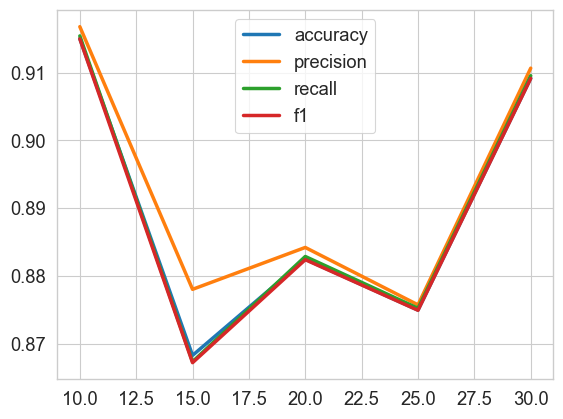

In [160]:
# plot the results by number of clusters
plt.plot(res_gisette['n_clusters'], res_gisette['accuracy'], label='accuracy')
plt.plot(res_gisette['n_clusters'], res_gisette['precision'], label='precision')
plt.plot(res_gisette['n_clusters'], res_gisette['recall'], label='recall')
plt.plot(res_gisette['n_clusters'], res_gisette['f1'], label='f1')
plt.legend()
plt.savefig('Gisette_spectral_KNN.png')
plt.show()
# export the image

In [150]:
import seaborn as sns

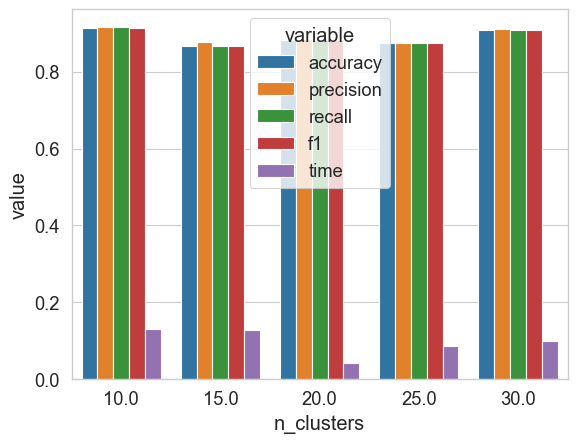

In [159]:
# Make a barplot of columns accuracy, precision, recall, f1 and time of res_gisette
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.barplot(x='n_clusters', y='value', hue='variable', data=pd.melt(res_gisette, ['n_clusters']))
plt.savefig('Gisette_spectral_KNN_barplot.png')
plt.show()
# export the image

In [161]:
res_gisette.to_latex('Gisette_spectral_KNN.tex')

C:\Users\HP\AppData\Local\Temp\ipykernel_16056\1228663263.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  res_gisette.to_latex('Gisette_spectral_KNN.tex')
